# Source Mixing with NMF

Now, instead of looking at a single light curve, it seems to make sense to to generate $K$ light curves with either one event or one heating frequency per light curve. Each of these consists of of $M$ samples (in time). We can then mix these to simulate $N$ observations.

Consider the matrix $X$ such that $X\in\mathbf{R}^{+}_{K\times M}$. So $X$ is just the $K$ individual sources stacked on top of each other. These are mixed by $A\in\mathbf{R}^{+}_{N\times K}$. Thus, $Y\in\mathbf{R}^{+}_{M\times N}$ represents the $N$ observations, each with $M$ samples, stacked on top of each other. Our job then is to untangle these individual sources by decomposing $Y$ into $A$ and $M$. We will try to use NMF to do this. 

In [1]:
#import needed modules
import sys, os
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('papers')
%matplotlib inline
import chianti.core as ch
import sklearn.decomposition as skd

 found PyQt4 widgets
 using CLI for selections


/opt/anaconda3/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
sys.path.append('/home/wtb2/Documents/EBTEL_C/bin/')
sys.path.append('/home/wtb2/Documents/EBTEL_analysis/src/')
import ebtel_wrapper as ebw
import em_binner as emb

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


The workflow will be as follows:

+ Run EBTEL $K$ times with $M$ samples for either:
    + $K$ heating events at different times 
    + $K$ heating frequencies
+ Calculate $\mathrm{EM}(T)$ for each of the $K$ EBTEL runs
+ Use CHIANTI to generate a lightcurve for each EBTEL run
+ Mix these observations with $A$ to generate $Y$
+ Run NMF minimization on $Y$

First set up the general EBTEL dictionary that we will use for all of the runs.

In [3]:
#input dictionary
config_dict = {'usage_option':'dem','rad_option':'rk','dem_option':'new','heat_flux_option':'classical',
              'solver':'euler','ic_mode':'st_eq','print_plasma_params':'True'}
config_dict['total_time'] = 10000
config_dict['tau'] = 1.0
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0/6.0
config_dict['h_back'] = 3.5e-5
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'file'
config_dict['t_end_switch'] = 'file'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp_switch'] = 'uniform'
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.1
config_dict['alpha'] = 2.
config_dict['loop_length'] = 40.0
config_dict['t_pulse_half'] = 100
config_dict['sample_rate'] = 1
config_dict['output_file'] = '/home/wtb2/Documents/research_notebook/NMF/ebtel_light_curve_mixing_test'

In [4]:
def run_print(input_dict,start_times,amp):
    """Configure number of heating events and start, end times; print config file and run model"""
    #set parameters
    input_dict['num_events'] = len(start_times)
    config_dict['h_nano'] = amp
    input_dict['start_time_array'] = start_times
    input_dict['end_time_array'] = start_times + 2.*input_dict['t_pulse_half']
    #print config file
    ebw.print_xml_config(input_dict,config_file=input_dict['output_file']+'.xml')
    #run
    ebw.run_ebtel('/home/wtb2/Documents/EBTEL_C/bin/','',config_file=input_dict['output_file']+'.xml',verbose=False)
    #quick look
    #ebw.plot_ebtel('',input_dict['output_file']+'.txt')
    #load data
    data = np.loadtxt(config_dict['output_file']+'.txt')
    return {'T':data[:,1],'n':data[:,2],'t':data[:,0]}

## Contribution Function

Let's calculate the contribution function $G(n,T)$ up front before we do anything else.

In [5]:
fe18 = ch.ion('fe_18',temperature=np.logspace(5.5,8,100),eDensity=1.e+9)

 ndens =     1 ntemp =   100
 - make a selection from these - 
     0      91.0411   29   98 2s2.2p4(1D).3p 2P1.5 - 2s.2p5(1P).3p 2S0.5 
     1      91.9888   54  104 2s2.2p4(1D).3d 2F3.5 - 2s.2p5(1P).3d 2F3.5 
     2      93.9322    1    3 2s2.2p5 2P1.5 - 2s.2p6 2S0.5 
 type the comma-separated index/indices of your selection
>>> 2


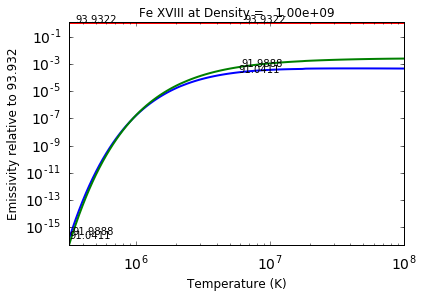

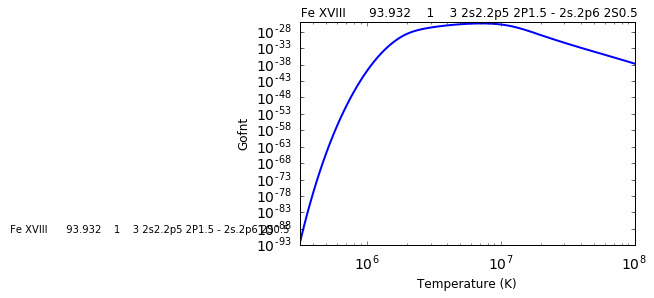

In [6]:
fe18.gofnt(wvlRange=[90,95],top=3)

## Single Pulses

Configure EBTEL runs with $K$ single pulses.

In [148]:
freq = np.linspace(50,5000,3)
qtot = 5
num_sources = 5#len(freq)
single_pulse_results = []

In [149]:
np.random.seed()
for i in range(num_sources):
    #get start time from distribution
    st = np.random.normal(config_dict['total_time']/2.,config_dict['total_time'],1)
    #st = np.arange(0,config_dict['total_time'],freq[i])
    #reject start times out of range
    while st < 0 or st + config_dict['total_time']/10. > config_dict['total_time']:
        st = np.random.normal(config_dict['total_time']/2.,config_dict['total_time'],1)
    amp = 0.1 #qtot/(config_dict['t_pulse_half'])*(freq[i] + 2.*config_dict['t_pulse_half'])/config_dict['total_time']
    #run EBTEL
    tmp = run_print(config_dict,st,amp)
    #calculate emission measure
    binner = emb.EM_Binner(tmp['t'],tmp['T'],tmp['n'],2.0*config_dict['loop_length']*1.e+8)
    binner.build_em_dist()
    tmp['logT_EM'] = binner.logT_EM
    tmp['DEM'] = binner.dem_mat
    #store results
    single_pulse_results.append(tmp)

Next, calculate the intensity (and average intensity) for each heating pulse.

In [150]:
Tmin = np.min(fe18.Gofnt['temperature'])
Tmax = np.max(fe18.Gofnt['temperature'])
tck_g = sc.interpolate.splrep(np.log10(fe18.Gofnt['temperature']),np.log10(fe18.Gofnt['gofnt']))
Imax = 0
Imax_avg = 0
for single in single_pulse_results:
    #preallocate
    T_EM = 10**single['logT_EM']    
    dlogT = single['logT_EM'][1] - single['logT_EM'][0] #assumes uniform spacing
    g = np.zeros(len(T_EM))
    g_avg = np.zeros(len(single['t']))
    intensity = np.zeros(len(single['t']))
    intensity_avg = np.zeros(len(single['t']))
    #interpolation
    ind_g = np.where((T_EM > Tmin) & (T_EM < Tmax))
    g[ind_g[0]] = 10.**(sc.interpolate.splev(single['logT_EM'][ind_g[0]],tck_g,der=0))
    #calculate intensity
    for i in range(len(single['t'])):
        intensity[i] = np.log(10.)*dlogT*np.sum(g*T_EM*single['DEM'][i,:])
    #interpolation
    ind_g_avg = np.where((single['T'] > Tmin) & (single['T'] < Tmax))
    g_avg[ind_g_avg[0]] = 10.**(sc.interpolate.splev(np.log10(single['T'][ind_g_avg[0]]),tck_g,der=0))
    #calculate average intensity
    intensity_avg = single['n']**2*g_avg*2.*config_dict['loop_length']*1.e+8
    #add to dictionary
    single['I'] = intensity
    single['I_avg'] = intensity_avg
    #find max
    if np.max(intensity) > Imax:
        Imax = np.max(intensity)
    if np.max(intensity_avg) > Imax_avg:
        Imax_avg = np.max(intensity_avg)

Normalize to the maximum value across all light curves

In [151]:
for single in single_pulse_results:
    single['I'] = single['I']/Imax
    single['I_avg'] = single['I_avg']/Imax_avg

Now let's form all of these light curves into the $X$ matrix.

In [152]:
X = np.zeros([num_sources,len(single_pulse_results[0]['t'])])
for i in range(num_sources):
    X[i,:] = single_pulse_results[i]['I_avg']

Plot the sources.

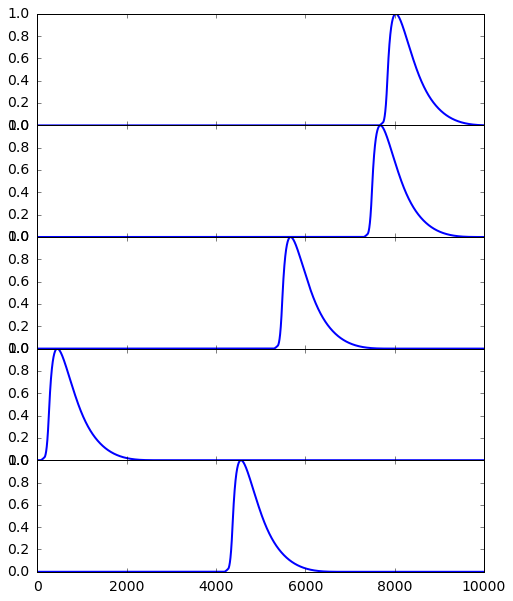

In [153]:
fig,ax = plt.subplots(num_sources,1,figsize=(8,2*num_sources),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0)
for i in range(num_sources):
    ax[i].plot(single_pulse_results[i]['t'],X[i,:])
    ax[i].set_xlim([single_pulse_results[i]['t'][0],single_pulse_results[i]['t'][-1]])

Now we'll create our mixing matrix $A$

In [154]:
num_observers = 200
A = np.random.rand(num_observers,num_sources)

Synthesize the $N\times M$ observation matrix $Y$

In [155]:
Y = np.dot(A,X)

Plot the $N$ convoluted observations 

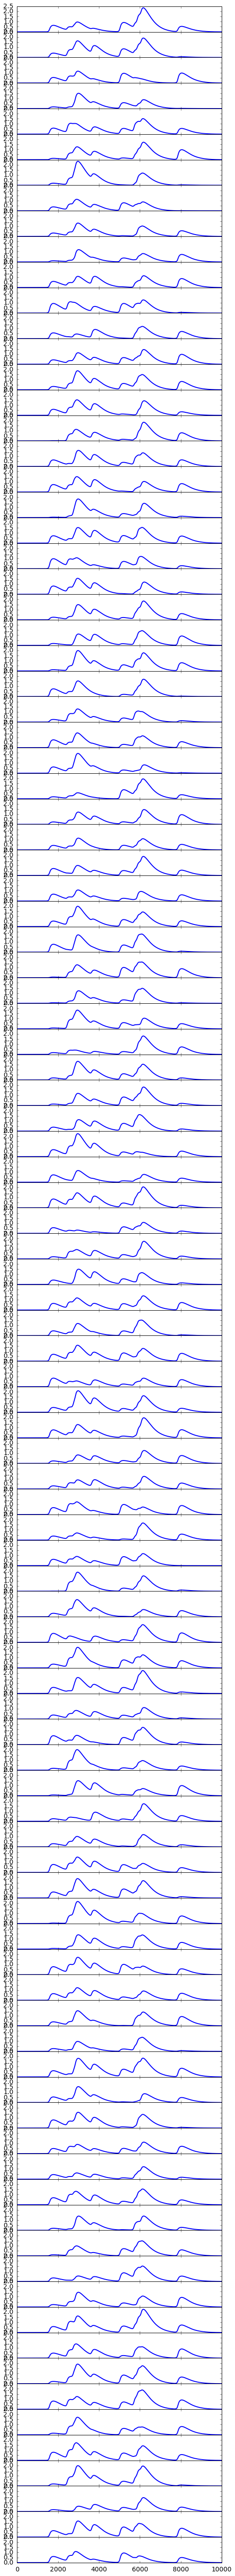

In [30]:
fig,ax = plt.subplots(num_observers,1,figsize=(8,num_observers),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0)
for i in range(num_observers):
    ax[i].plot(single_pulse_results[0]['t'],Y[i,:])
    ax[i].set_xlim([single_pulse_results[0]['t'][0],single_pulse_results[0]['t'][-1]])

So now that we have our observation matrix $Y$, we can apply it to our NMF method.

First, set up the model with the desired parameters

In [156]:
model = skd.NMF(n_components=num_sources,init='nndsvd',random_state=0,verbose=0,
                alpha=1.0,l1_ratio=0.0,solver='cd',max_iter=500,shuffle=True)

Split into a training set and a test set

In [157]:
Y_train,Y_test = Y[0:int(len(Y)/2),:],Y[(int(len(Y)/2)+1):-1,:]

In [158]:
model.fit(Y)

NMF(alpha=1.0, beta=1, eta=0.1, init='nndsvd', l1_ratio=0.0, max_iter=500,
  n_components=5, nls_max_iter=2000, random_state=0, shuffle=True,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [159]:
U = model.transform(np.sum(X,axis=0).reshape(1,-1))
V = model.components_

Try plotting the $V$ matrix to see what the entries look like.

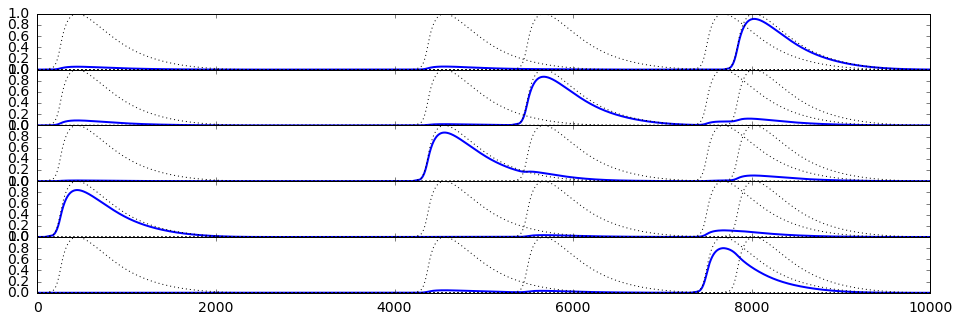

In [160]:
fig,ax = plt.subplots(num_sources,1,figsize=(16,num_sources),sharex=True)
plt.subplots_adjust(hspace=0)
for i in range(num_sources):
    ax[i].plot(single_pulse_results[i]['t'],np.sum(np.outer(U[:,i],V[i,:]),axis=0))
    ax[i].set_xlim([single_pulse_results[i]['t'][0],single_pulse_results[i]['t'][-1]])
    for j in range(num_sources):
        ax[i].plot(single_pulse_results[i]['t'],X[j,:],'k:',linewidth=1)
        ax[i].set_xlim([single_pulse_results[i]['t'][0],single_pulse_results[i]['t'][-1]])

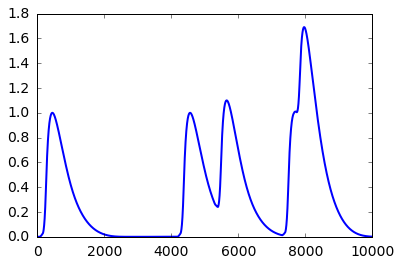

In [161]:
plt.plot(single_pulse_results[0]['t'],np.sum(X,axis=0))